# RL-Based Cost-Aware Maintenance Scheduling
This notebook demonstrates how reinforcement learning can be used to schedule maintenance based on predicted RUL values, cost trade-offs, and risk of failure.
It aligns with reviewer suggestions on dynamic optimization and actionable decision-making.

In [3]:
import numpy as np
import matplotlib.pyplot as plt
import random
%pip install gym
import gym
from gym import spaces

np.random.seed(42)
random.seed(42)


[notice] A new release of pip is available: 23.0.1 -> 25.1.1
[notice] To update, run: pip install --upgrade pip
Note: you may need to restart the kernel to use updated packages.


In [4]:
class MaintenanceEnv(gym.Env):
    def __init__(self):
        super().__init__()
        self.max_rul = 100
        self.rul = self.max_rul
        self.time = 0
        self.done = False
        self.action_space = spaces.Discrete(2)  # 0 = do nothing, 1 = perform maintenance
        self.observation_space = spaces.Box(low=0, high=self.max_rul, shape=(1,), dtype=np.float32)
        self.maintenance_cost = 30
        self.failure_cost = 100

    def reset(self):
        self.rul = self.max_rul
        self.time = 0
        self.done = False
        return np.array([self.rul], dtype=np.float32)

    def step(self, action):
        reward = 0
        if action == 1:  # perform maintenance
            reward = -self.maintenance_cost
            self.rul = self.max_rul
        else:  # no maintenance
            self.rul -= np.random.randint(1, 10)
            if self.rul <= 0:
                reward = -self.failure_cost
                self.done = True

        self.time += 1
        if self.time >= 50:
            self.done = True

        return np.array([self.rul], dtype=np.float32), reward, self.done, {}

In [5]:
# Simple Q-learning agent for scheduling
env = MaintenanceEnv()
q_table = np.zeros((env.max_rul+1, env.action_space.n))

alpha = 0.1
gamma = 0.95
epsilon = 0.1
episodes = 1000

for ep in range(episodes):
    state = env.reset()[0]
    done = False
    while not done:
        state_idx = int(state)
        if random.uniform(0, 1) < epsilon:
            action = env.action_space.sample()
        else:
            action = np.argmax(q_table[state_idx])
        next_state, reward, done, _ = env.step(action)
        next_state_idx = int(next_state[0])
        q_table[state_idx, action] += alpha * (reward + gamma * np.max(q_table[next_state_idx]) - q_table[state_idx, action])
        state = next_state[0]

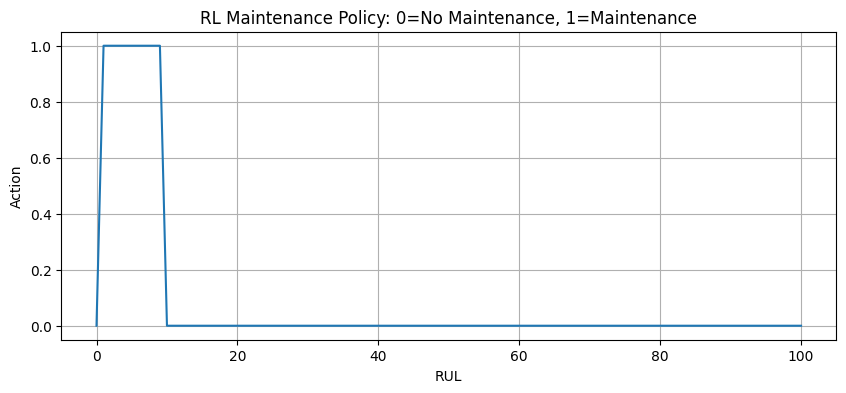

In [6]:
# Evaluate learned policy
maintenance_policy = [np.argmax(q_table[rul]) for rul in range(env.max_rul+1)]
plt.figure(figsize=(10,4))
plt.plot(maintenance_policy)
plt.title('RL Maintenance Policy: 0=No Maintenance, 1=Maintenance')
plt.xlabel('RUL')
plt.ylabel('Action')
plt.grid(True)
plt.show()